# Groups

In [10]:
import numpy as np

model_name = "pythia_160m"
n_tokens = 10_000_000
method = "cka"
n_tokens_label = f"{float(n_tokens) / 1e6:.1f}M"

dist = np.load(f"../dist/{model_name}_{n_tokens_label}_{method}.npy")
nl = dist.shape[0]
dist.shape

(12, 12)

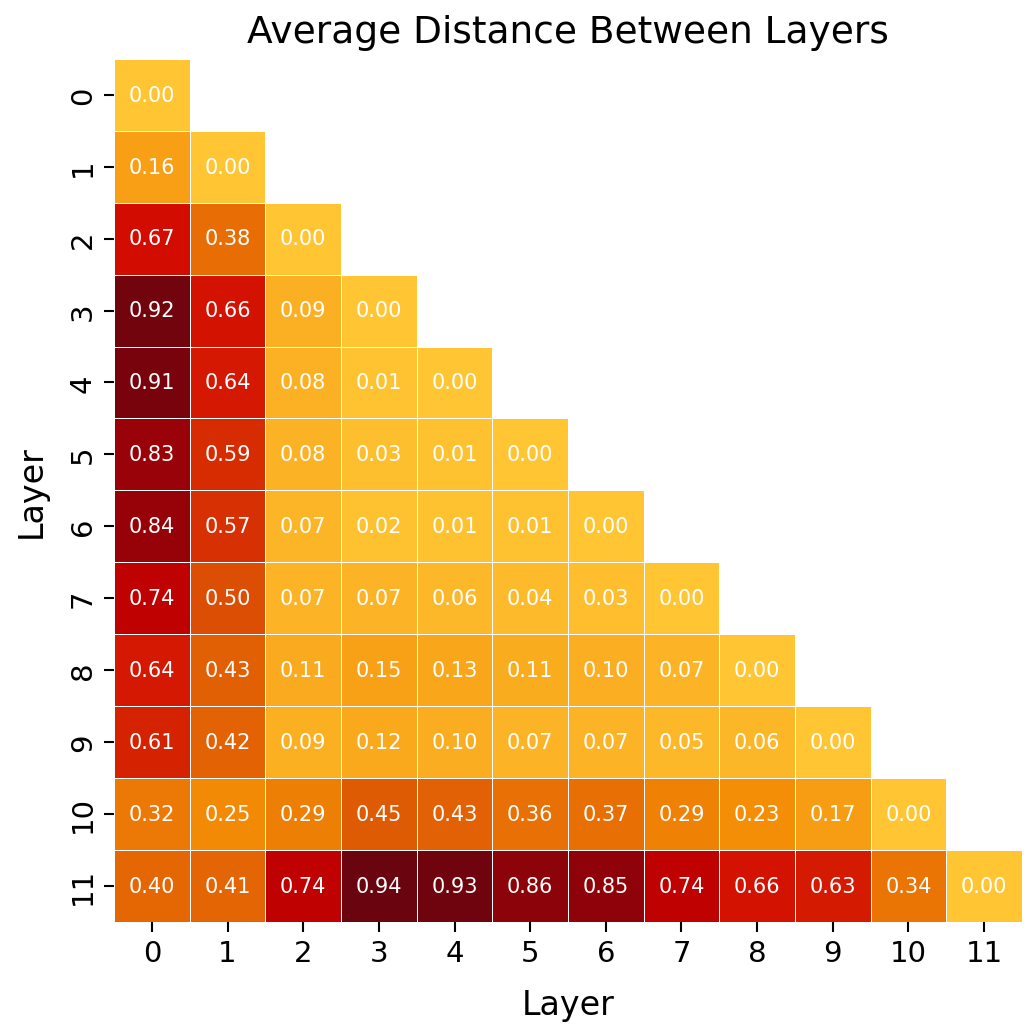

In [11]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

from group_sae.utils import cmap

os.makedirs("img", exist_ok=True)

sns.set_context("paper")
scale = nl / 25
fig, ax = plt.subplots(1, 1, figsize=(int(16 * scale), int(15 * scale)), dpi=150, layout="tight")  # 12, 11

cmap.set_bad("white")
dist_bad = np.copy(dist)
dist_bad[np.triu_indices_from(dist_bad, 1)] = np.nan
mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)

sns.heatmap(
    dist_bad,
    cmap=cmap,
    vmin=0,
    annot=True,
    fmt=".2f",
    ax=ax,
    mask=np.triu(dist),
    square=False,
    linewidths=0.3,
    linecolor="white",
    cbar=False,
    annot_kws={"size": 10, "color": "white"},
)

ax.set_title("Average Distance Between Layers", pad=8, fontsize=18)
# ax.set_ylim(0, 1)

ax.set_xlabel("Layer", labelpad=10, fontsize=16)
ax.set_ylabel("Layer", labelpad=10, fontsize=16)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.savefig(f"img/{model_name}_{n_tokens}.pdf", dpi=300, bbox_inches="tight")

In [9]:
import json

from sklearn.cluster import AgglomerativeClustering

scores = []
num_batches = 2000

X = np.array(dist) #[:-1, :-1])
X[np.isinf(X)] = 0
X[np.isnan(X)] = 0
X = np.nan_to_num(X)

clusters = {}

for k in range(1, nl // 2 + 1):
    clustering = AgglomerativeClustering(
        n_clusters=k, linkage="complete", compute_distances=True
    ).fit(X)

    cluster_dist = [X[clustering.labels_ == i][:, clustering.labels_ == i].max() for i in range(k)]
    print(f"K{k}:\t", clustering.labels_, "AMD:", np.round(np.mean(cluster_dist), 3)) # Weight by cluster size!

    clusters[k] = {
        "labels": [str(i) for i in clustering.labels_],
        "maad": float(np.round(max(cluster_dist), 3))
    }

with open(f"maad/{model_name}.json", "w") as f:
    json.dump(clusters, f)

K1:	 [0 0 0 0 0 0 0 0 0 0 0 0] AMD: 0.473
K2:	 [1 1 1 1 1 1 1 0 0 0 0 0] AMD: 0.411
K3:	 [0 0 0 0 0 0 0 1 1 1 1 2] AMD: 0.248
K4:	 [3 3 3 1 1 1 1 0 0 0 0 2] AMD: 0.235
K5:	 [1 1 1 0 0 0 0 3 3 4 4 2] AMD: 0.214
K6:	 [0 0 0 2 2 3 3 1 1 4 4 5] AMD: 0.193
